In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# **Config and Device**

In [34]:
# Global configuration
IMAGE_PATH_2 = "/content/t2.png"  # Path to the image for sentence recognition
IMAGE_PATH_1 = "/content/t1.png"
SEED = 1  # Random seed for reproducibility

In [3]:
def get_device():
    """Configure the device for training or inference."""
    use_cuda = torch.cuda.is_available()
    use_mps = torch.backends.mps.is_available()

    if use_cuda:
        return torch.device("cuda")
    elif use_mps:
        return torch.device("mps")
    else:
        return torch.device("cpu")

In [4]:
get_device()

device(type='cuda')

# **CNN Architecture**

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # First conv block
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.bn1 = nn.BatchNorm2d(32)

        # Second conv block
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.bn2 = nn.BatchNorm2d(64)

        # Third conv block (new)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.bn3 = nn.BatchNorm2d(128)

        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)

        # Calculate the size for the fully connected layer
        self.fc1 = nn.Linear(3200, 256)  # Adjusted size
        self.fc2 = nn.Linear(256, 62)

    def forward(self, x):
        # First block
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        # Second block
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        # Third block
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)

        # Fully connected layers
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)


In [6]:
def train(model, device, train_loader, optimizer, epoch, log_interval=10):
    model.train()
    total_loss = 0
    correct = 0
    total_samples = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total_samples += target.size(0)

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total_samples
    return avg_loss, accuracy

In [7]:
def test(model, device, test_loader):
    model.eval()
    total_loss = 0
    correct = 0
    total_samples = 0
    correct_images = []
    correct_labels = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            total_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total_samples += target.size(0)

            # Save correctly classified images and labels for visualization
            for i in range(len(target)):
                if pred[i] == target[i]:
                    correct_images.append(data[i].cpu())
                    correct_labels.append(pred[i].item())
                    if len(correct_images) >= 10:  # Limit to 10 correct predictions
                        break

    avg_loss = total_loss / len(test_loader.dataset)
    accuracy = correct / total_samples
    return avg_loss, accuracy, correct_images, correct_labels

In [8]:
def plot_metrics(train_losses, test_losses, train_accuracies, test_accuracies):
    """Plot train/test loss and accuracy over epochs."""
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))
    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, test_losses, label="Test Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Train vs Test Loss")
    plt.legend()
    plt.grid()

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Train Accuracy")
    plt.plot(epochs, test_accuracies, label="Test Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Train vs Test Accuracy")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

In [9]:
def plot_correct_predictions(images, labels, num_samples=10):
    """Plot correctly classified single letters and digits."""
    num_samples = min(num_samples, len(images))

    plt.figure(figsize=(15, 3))
    for i in range(num_samples):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].squeeze(), cmap="gray")

        # Updated mapping for byclass dataset
        if 0 <= labels[i] <= 9:  # Digits (0-9)
            label_char = str(labels[i])
        elif 10 <= labels[i] <= 35:  # Uppercase letters (A-Z)
            label_char = chr(labels[i] - 10 + ord('A'))
        else:  # Lowercase letters (a-z)
            label_char = chr(labels[i] - 36 + ord('a'))

        plt.title(f"Label: {label_char}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

In [23]:
def segment_characters(image_path):
    """
    Improved segmentation for handwritten text.
    """
    # Read image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Add padding to the image
    padding = 10
    img = cv2.copyMakeBorder(img, padding, padding, padding, padding,
                            cv2.BORDER_CONSTANT, value=255)

    # Apply adaptive thresholding
    binary_img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                     cv2.THRESH_BINARY_INV, 11, 2)

    # Dilate to connect components
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    binary_img = cv2.dilate(binary_img, kernel, iterations=1)

    # Find contours
    contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL,
                                  cv2.CHAIN_APPROX_SIMPLE)

    # Filter and sort ROIs
    rois = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w > 5 and h > 5:  # Filter small noise
            # Extract ROI
            roi = binary_img[y:y+h, x:x+w]

            # Add padding to ROI
            roi = cv2.copyMakeBorder(roi, 5, 5, 5, 5,
                                   cv2.BORDER_CONSTANT, value=0)

            rois.append((roi, (x, y, w, h)))

    # Sort ROIs from left to right
    rois = sorted(rois, key=lambda r: r[1][0])

    return rois, img

In [24]:
def recognize_sentence(image_path, model, device):
    """
    Improved recognition function with better preprocessing.
    """
    rois, original_image = segment_characters(image_path)

    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    predictions = []

    # Visualization setup
    plt.figure(figsize=(15, 5))

    # Plot original image
    plt.subplot(2, 1, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # Plot segmented characters
    plt.subplot(2, 1, 2)
    num_rois = len(rois)
    for idx, (roi, (x, y, w, h)) in enumerate(rois):
        # Prepare ROI for model
        roi_tensor = transform(roi).unsqueeze(0).to(device)

        # Get prediction
        with torch.no_grad():
            output = model(roi_tensor)
            pred = output.argmax(dim=1).item()

            # Convert prediction to character
            if 0 <= pred <= 9:
                char = str(pred)
            elif 10 <= pred <= 35:
                char = chr(pred - 10 + ord('A'))
            else:
                char = chr(pred - 36 + ord('a'))

            predictions.append(char)

        # Plot segmented character
        plt.subplot(2, num_rois, idx + num_rois + 1)
        plt.imshow(roi, cmap='gray')
        plt.title(f'Pred: {char}')
        plt.axis('off')

    sentence = ''.join(predictions)
    plt.suptitle(f'Recognized Text: {sentence}', y=1.05)
    plt.tight_layout()
    plt.show()

    return sentence


In [28]:
def test_recognition(image_path):
    device = get_device()
    model = Net().to(device)
    model.load_state_dict(torch.load("best_emnist_cnn.pt"))
    model.eval()

    result = recognize_sentence(image_path, model, device)
    print(f"Recognized text: {result}")

In [12]:
def main():
    # Training settings
    batch_size = 128
    test_batch_size = 1000
    epochs = 30
    learning_rate = 0.01
    save_model = True

    # Set device and seed
    device = get_device()
    torch.manual_seed(SEED)

    # Data augmentation and transformations
    transform_train = transforms.Compose([
        transforms.RandomRotation(10),
        transforms.RandomAffine(
            degrees=0,
            translate=(0.1, 0.1),
            scale=(0.9, 1.1),
        ),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    # Load EMNIST dataset
    dataset1 = datasets.EMNIST('../data', split='byclass', train=True,
                              download=True, transform=transform_train)
    dataset2 = datasets.EMNIST('../data', split='byclass', train=False,
                              transform=transform_test)

    train_loader = DataLoader(dataset1, batch_size=batch_size,
                             shuffle=True, num_workers=2)
    test_loader = DataLoader(dataset2, batch_size=test_batch_size,
                            shuffle=False, num_workers=2)

    # Model setup
    model = Net().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='max',
        factor=0.5,
        patience=3,
        verbose=True
    )

    # Metrics tracking
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []
    best_accuracy = 0

    # Training loop
    for epoch in range(1, epochs + 1):
        train_loss, train_accuracy = train(model, device, train_loader,
                                         optimizer, epoch)
        test_loss, test_accuracy, correct_images, correct_labels = test(
            model, device, test_loader)

        # Update learning rate based on test accuracy
        scheduler.step(test_accuracy)

        # Save metrics
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        # Save best model
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            if save_model:
                torch.save(model.state_dict(), "best_emnist_cnn.pt")

        print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, "
              f"Train Acc={train_accuracy:.4f}, "
              f"Test Loss={test_loss:.4f}, "
              f"Test Acc={test_accuracy:.4f}")

    return (model, train_losses, test_losses, train_accuracies,
            test_accuracies, correct_images, correct_labels)

In [15]:
if __name__ == '__main__':
    # Run training
    results = main()
    model, train_losses, test_losses, train_accuracies, test_accuracies, correct_images, correct_labels = results

Streaming output truncated to the last 5000 lines.
Train Epoch: 21 [601600/697932 (86%)]	Loss: 0.639466
Train Epoch: 21 [602880/697932 (86%)]	Loss: 0.863349
Train Epoch: 21 [604160/697932 (87%)]	Loss: 0.580176
Train Epoch: 21 [605440/697932 (87%)]	Loss: 0.727781
Train Epoch: 21 [606720/697932 (87%)]	Loss: 1.006804
Train Epoch: 21 [608000/697932 (87%)]	Loss: 0.654122
Train Epoch: 21 [609280/697932 (87%)]	Loss: 0.652909
Train Epoch: 21 [610560/697932 (87%)]	Loss: 0.542872
Train Epoch: 21 [611840/697932 (88%)]	Loss: 0.682566
Train Epoch: 21 [613120/697932 (88%)]	Loss: 0.736502
Train Epoch: 21 [614400/697932 (88%)]	Loss: 0.854473
Train Epoch: 21 [615680/697932 (88%)]	Loss: 0.818633
Train Epoch: 21 [616960/697932 (88%)]	Loss: 0.910091
Train Epoch: 21 [618240/697932 (89%)]	Loss: 0.614851
Train Epoch: 21 [619520/697932 (89%)]	Loss: 0.766397
Train Epoch: 21 [620800/697932 (89%)]	Loss: 0.553882
Train Epoch: 21 [622080/697932 (89%)]	Loss: 0.719884
Train Epoch: 21 [623360/697932 (89%)]	Loss: 0.74

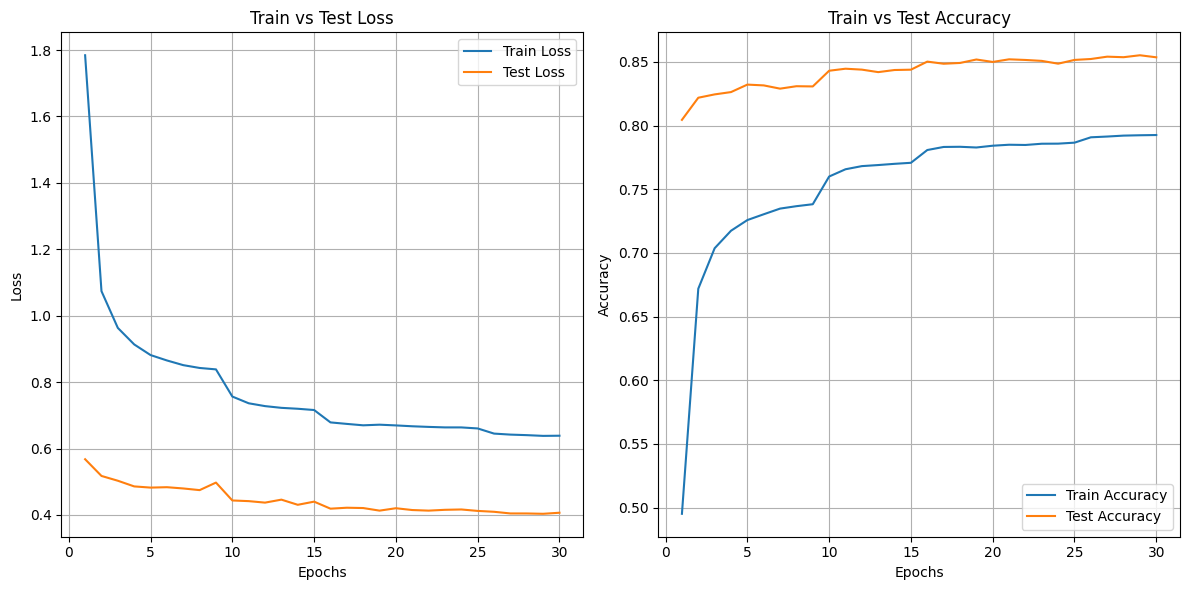

In [16]:
plot_metrics(train_losses, test_losses, train_accuracies, test_accuracies)

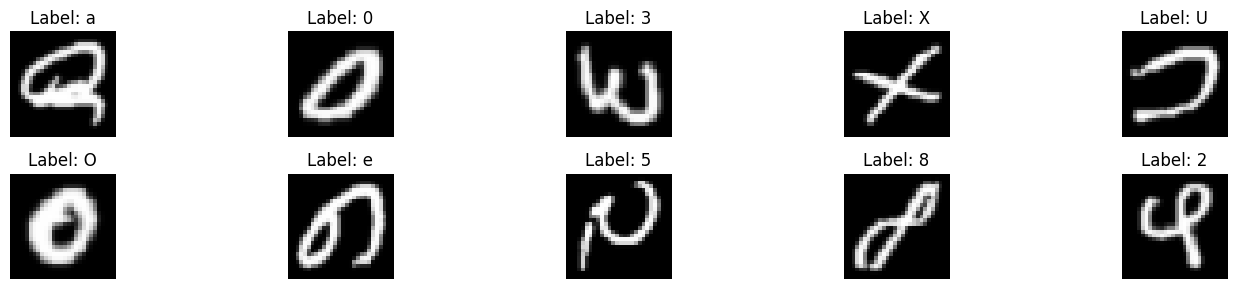

In [17]:
plot_correct_predictions(correct_images, correct_labels)

<ipython-input-28-26d2ed422454>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_emnist_cnn.pt"))


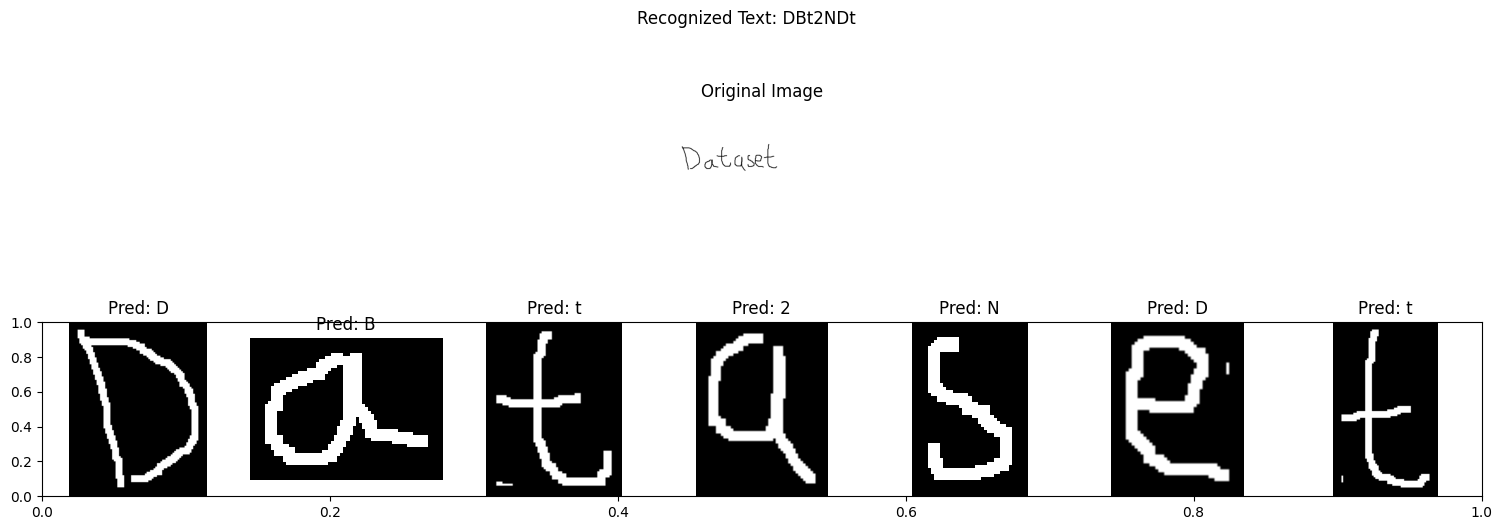

Recognized text: DBt2NDt


In [35]:
test_recognition(IMAGE_PATH_1)

<ipython-input-28-26d2ed422454>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_emnist_cnn.pt"))


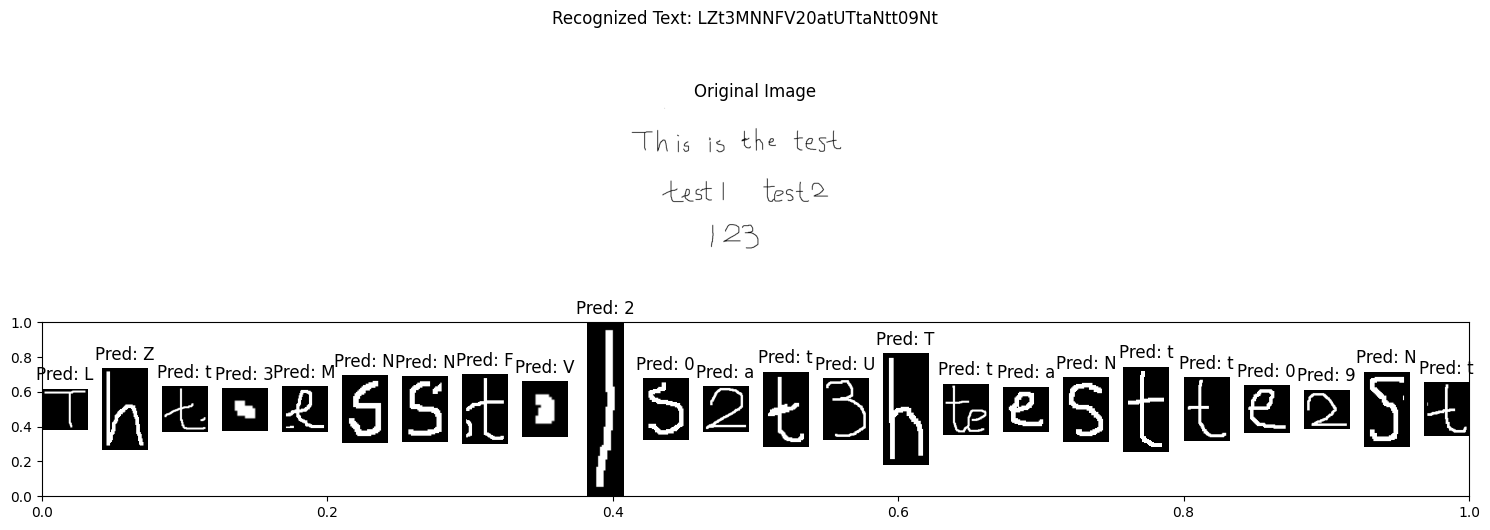

Recognized text: LZt3MNNFV20atUTtaNtt09Nt


In [36]:
test_recognition(IMAGE_PATH_2)